Check where my python env is

In [1]:
import sys

In [2]:
sys.executable

'/media/pandoora/DATA/programms/Anaconda/envs/tf_gpu/bin/python3'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, random  

Imports for Neural Network

In [4]:
import tensorflow as tf
keras = tf.keras
Sequential =  keras.models.Sequential
Dense = keras.layers.Dense
Activation =  keras.layers.Activation
metrics = keras.metrics
Dropout = keras.layers.Dropout
ModelCheckpoint = keras.callbacks.ModelCheckpoint
KerasClassifier = keras.wrappers.scikit_learn.KerasClassifier

Imports for Helpertools and Models

In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

from bayes_opt import BayesianOptimization
from joblib import Parallel, delayed

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

Setting Seed 

In [7]:
seed = 7

In [8]:
def rounding(digits, threshold = 0.50):
    """rounds a list of float digits with own threshhold"""
    if type(digits) == list  or  type(digits) == np.ndarray:
        return np.array(list(map(rounding, digits)))
    elif type(digits)== np.float64 or type(digits)== np.float32:
        k = digits % 1
        f = digits - k

        if k >= threshold:
            return int((f + 1))
        else:
            return int(f)
    else:
        raise ValueError("Wrong Type")

In [9]:
def binary_enc(dataframe, colname):
    """cast a string into a binary int variable
    
    Arguments:
        dataframe: DataFrame to change
        colname:   String Column that has to change
        
    Return:
        the changed DataFrame
    
    """
    temp_df = dataframe.copy(deep=True)

    var_1, var_2 = temp_df.loc[:,colname].unique()
    #print(var_1, ": 1")
    #print(var_2, ": 0")

    mapper = {
        var_1: 1 ,
        var_2: 0 
    }   
    #print(mapper)
    
    temp_df[colname] = temp_df[colname].replace(mapper)
    return temp_df, mapper

In [10]:
def binary_encoding(dataframe, colnames):
    """casts a string variabl into a binary integer variable
    
    Arguments:
        dataframe: DataFrame to change
        colname:   String Column that has to change
        
    Return:
        the changed DataFrame with a binary integer columns
    
    """
    temp_df = dataframe.copy(deep=True)
    
    maps = {   }

    if type(colnames) == list:
        for i, col in enumerate(colnames):
            temp_df, dictionary = binary_enc(temp_df, col)
            #maps.update( {colnames : dictionary} )
            
            maps.update( {col : dictionary} )
    else:
        temp_df, dictionary = binary_enc(temp_df, colnames)
            
    return temp_df,maps

In [11]:
def zscore_normalisation(dataframe, colname):
    """zscore transformation 
    
    Arguments:
        dataframe: DataFrame to change
    Return:
        the changed DataFrame        
    """
    temp_df = dataframe.copy(deep=True)
    temp_df[colname] = (temp_df[colname] - temp_df[colname].mean()) / temp_df[colname].std()
    
    return temp_df

In [12]:
def split_dataframe(dataframe, colname):
    """ splitting data frame in to two dataframes
    
    Arguments:
        dataframe: DataFrame to change
        colname:   the selected column would be splitt and returned in a different dataframe
        
    Return:
        dataframe without the given colname
        dataframe with only the colname
    """
    temp_df = dataframe.copy(deep=True)
    
    ordinal_column_df = temp_df.loc[:, colname]
    not_ordinal_df = temp_df.drop(columns=colname)
    return ordinal_column_df, not_ordinal_df

Loading the DataFrame

In [13]:
einkommen = pd.read_csv("einkommen.train")

Ranaming the columns from the Description

In [14]:
# changing index cols with 
einkommen.columns = ['Age', 'Employment', 'Weighting_factor', 'Level_of_education', 
                'Schooling_period', 'Marital_status', 'Employment_area', 'Partnership', 
                'Ethnicity', 'Gender', 'Gains_on_financial assets', 'Losses_on_financial_assets', 
                'Weekly_working_time', 'Country_of birth','Income'] 

Checking the DataFrame

In [15]:
einkommen.shape

(29999, 15)

It has 30K Rows and 15 Columns

In [16]:
einkommen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 15 columns):
Age                           29999 non-null int64
Employment                    29999 non-null object
Weighting_factor              29999 non-null int64
Level_of_education            29999 non-null object
Schooling_period              29999 non-null int64
Marital_status                29999 non-null object
Employment_area               29999 non-null object
Partnership                   29999 non-null object
Ethnicity                     29999 non-null object
Gender                        29999 non-null object
Gains_on_financial assets     29999 non-null int64
Losses_on_financial_assets    29999 non-null int64
Weekly_working_time           29999 non-null int64
Country_of birth              29999 non-null object
Income                        29999 non-null object
dtypes: int64(6), object(9)
memory usage: 3.4+ MB


get the 5000 rows with given Target

In [17]:
set_1 = einkommen[:4999]

In [18]:
set_1.shape

(4999, 15)

In [19]:
print(set_1[:3])

   Age         Employment  Weighting_factor Level_of_education  \
0   50   Self-emp-not-inc             83311          Bachelors   
1   38            Private            215646            HS-grad   
2   53            Private            234721               11th   

   Schooling_period       Marital_status     Employment_area     Partnership  \
0                13   Married-civ-spouse     Exec-managerial         Husband   
1                 9             Divorced   Handlers-cleaners   Not-in-family   
2                 7   Married-civ-spouse   Handlers-cleaners         Husband   

  Ethnicity Gender  Gains_on_financial assets  Losses_on_financial_assets  \
0     White   Male                          0                           0   
1     White   Male                          0                           0   
2     Black   Male                          0                           0   

   Weekly_working_time Country_of birth  Income  
0                   13    United-States   <=50K  
1    

In [20]:
set_1.head()

,Age,Employment,Weighting_factor,Level_of_education,Schooling_period,Marital_status,Employment_area,Partnership,Ethnicity,Gender,Gains_on_financial assets,Losses_on_financial_assets,Weekly_working_time,Country_of birth,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


which col has numbers?

In [21]:
int_col = [col for i, col in enumerate(set_1.columns) if set_1[col].dtype == int ]

In [22]:
print("integer cols:",int_col)

integer cols: ['Age', 'Weighting_factor', 'Schooling_period', 'Gains_on_financial assets', 'Losses_on_financial_assets', 'Weekly_working_time']


all columns which has numbers would be  z- normalized

In [23]:
znorm_df = zscore_normalisation(set_1, int_col)

In [24]:
print(znorm_df[:3])

        Age         Employment  Weighting_factor Level_of_education  \
0  0.838470   Self-emp-not-inc         -1.010548          Bachelors   
1 -0.044139            Private          0.233691            HS-grad   
2  1.059122            Private          0.413038               11th   

   Schooling_period       Marital_status     Employment_area     Partnership  \
0          1.152342   Married-civ-spouse     Exec-managerial         Husband   
1         -0.425677             Divorced   Handlers-cleaners   Not-in-family   
2         -1.214687   Married-civ-spouse   Handlers-cleaners         Husband   

  Ethnicity Gender  Gains_on_financial assets  Losses_on_financial_assets  \
0     White   Male                  -0.146532                   -0.228107   
1     White   Male                  -0.146532                   -0.228107   
2     Black   Male                  -0.146532                   -0.228107   

   Weekly_working_time Country_of birth  Income  
0            -2.272353    United-St

which columns have nominals?

In [25]:
nominal_col = [col for i, col in enumerate(znorm_df.columns) if set_1[col].dtype != int ]

In [26]:
print("nonimal columns:", nominal_col)

nonimal columns: ['Employment', 'Level_of_education', 'Marital_status', 'Employment_area', 'Partnership', 'Ethnicity', 'Gender', 'Country_of birth', 'Income']


In [27]:
print(set_1.columns)
print(set_1["Age"].unique())
print(set_1["Weekly_working_time"].unique())
print(set_1["Schooling_period"].unique())

Index(['Age', 'Employment', 'Weighting_factor', 'Level_of_education',
       'Schooling_period', 'Marital_status', 'Employment_area', 'Partnership',
       'Ethnicity', 'Gender', 'Gains_on_financial assets',
       'Losses_on_financial_assets', 'Weekly_working_time', 'Country_of birth',
       'Income'],
      dtype='object')
[50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 39 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83]
[13 40 16 45 50 80 30 35 60 20 52 44 15 25 38 43 55 48 58 32 70  2 22 56
 41 28 36 24 46 42 12 65  1 10 34 75 98 33 54  8  6 64 19 18 72  5  9 47
 37 21 26 14  4 59  7 99 53 39 62 57 78 90 66 11 49 84  3 17 68 27 85 31
 51 77]
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


Checking for missing values in nominals

In [28]:
print("Check for Missing values in nominal")
for i,col in enumerate(nominal_col):
    print(i,"Number of ? contains in ",col, sum(znorm_df[col].str.contains('?', regex=False))) 

Check for Missing values in nominal
0 Number of ? contains in  Employment 331
1 Number of ? contains in  Level_of_education 0
2 Number of ? contains in  Marital_status 0
3 Number of ? contains in  Employment_area 331
4 Number of ? contains in  Partnership 0
5 Number of ? contains in  Ethnicity 0
6 Number of ? contains in  Gender 0
7 Number of ? contains in  Country_of birth 97
8 Number of ? contains in  Income 0


checking for nominals with only 2 values to transform the in to binary integer

In [29]:
binary_columns = []
for i, col in enumerate(nominal_col):
    unique_names = set_1.loc[:,col].unique()
    if len(unique_names) == 2:
        binary_columns.append(col)

In [30]:
bin_encoded_df, maps = binary_encoding(znorm_df,binary_columns)
print("Dictionary for binary encodings: \n", maps)

Dictionary for binary encodings: 
 {'Gender': {' Male': 1, ' Female': 0}, 'Income': {' <=50K': 1, ' >50K': 0}}


In [31]:
print(bin_encoded_df[:3])

        Age         Employment  Weighting_factor Level_of_education  \
0  0.838470   Self-emp-not-inc         -1.010548          Bachelors   
1 -0.044139            Private          0.233691            HS-grad   
2  1.059122            Private          0.413038               11th   

   Schooling_period       Marital_status     Employment_area     Partnership  \
0          1.152342   Married-civ-spouse     Exec-managerial         Husband   
1         -0.425677             Divorced   Handlers-cleaners   Not-in-family   
2         -1.214687   Married-civ-spouse   Handlers-cleaners         Husband   

  Ethnicity  Gender  Gains_on_financial assets  Losses_on_financial_assets  \
0     White       1                  -0.146532                   -0.228107   
1     White       1                  -0.146532                   -0.228107   
2     Black       1                  -0.146532                   -0.228107   

   Weekly_working_time Country_of birth  Income  
0            -2.272353    Unite

In [32]:
bin_encoded_df.columns

Index(['Age', 'Employment', 'Weighting_factor', 'Level_of_education',
       'Schooling_period', 'Marital_status', 'Employment_area', 'Partnership',
       'Ethnicity', 'Gender', 'Gains_on_financial assets',
       'Losses_on_financial_assets', 'Weekly_working_time', 'Country_of birth',
       'Income'],
      dtype='object')

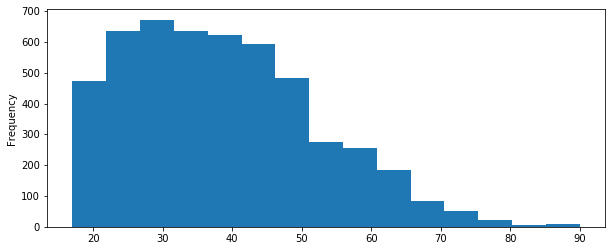

In [33]:
fig, ax = plt.subplots(figsize=(10,4))
set_1.Age.plot.hist(bins=15)
plt.show()

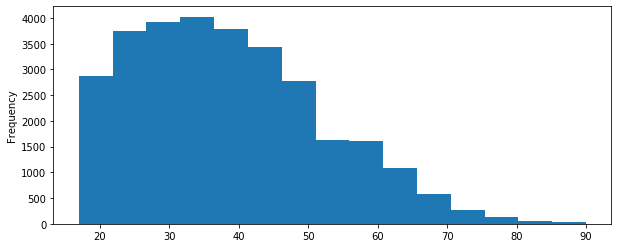

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
einkommen.Age.plot.hist(bins=15)
plt.show()

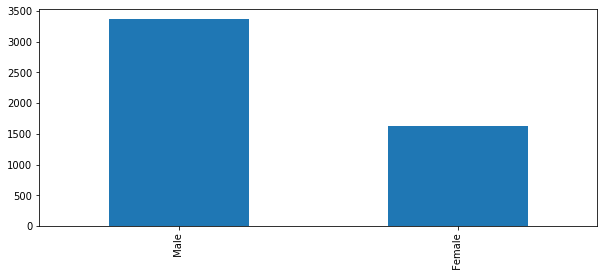

In [35]:
fig, ax = plt.subplots(figsize=(10,4))
set_1['Gender'].value_counts().plot(kind='bar')
plt.show()

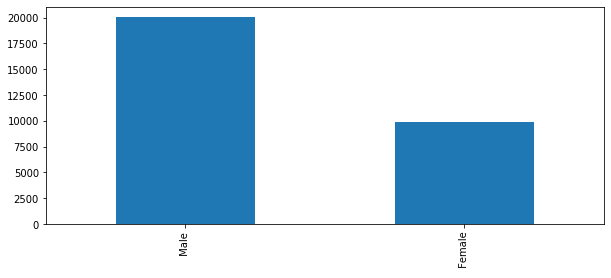

In [36]:
fig, ax = plt.subplots(figsize=(10,4))
einkommen['Gender'].value_counts().plot(kind='bar')
plt.show()

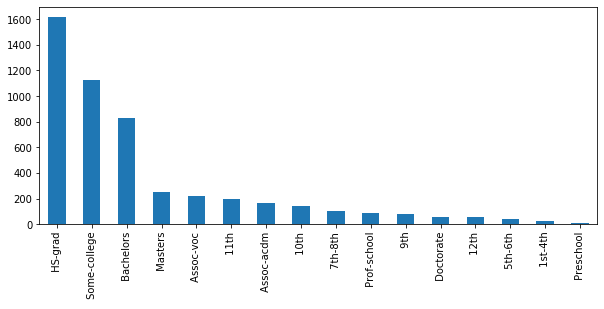

In [37]:
fig, ax = plt.subplots(figsize=(10,4))
bin_encoded_df['Level_of_education'].value_counts().plot(kind='bar')
plt.show()

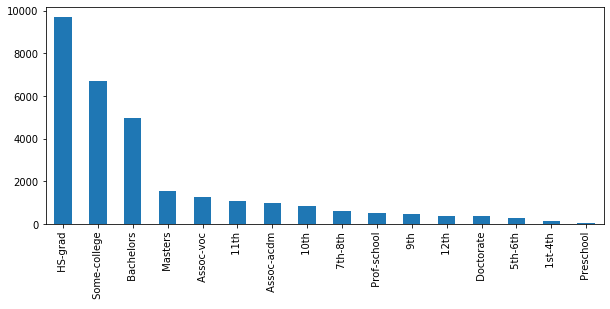

In [38]:
fig, ax = plt.subplots(figsize=(10,4))
einkommen['Level_of_education'].value_counts().plot(kind='bar')
plt.show()

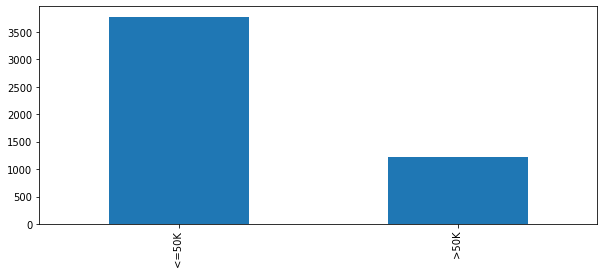

In [39]:
fig, ax = plt.subplots(figsize=(10,4))
set_1['Income'].value_counts().plot(kind='bar')
plt.show()

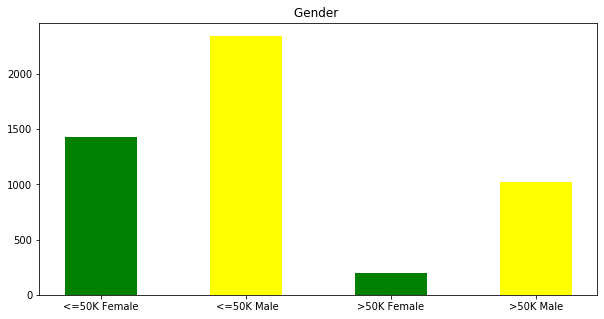

In [40]:
grouped_gender = set_1.groupby(['Income','Gender']).size()
grouped_gender_df =pd.DataFrame(grouped_gender)
grouped_gender_df.columns = ['Ammount']
pos = list(range(len(grouped_gender_df['Ammount']))) 
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Gender ')
plt.bar(pos, 
        #using df['pre_score'] data,
        grouped_gender_df['Ammount'], 
        # of width
        0.50, 
        color = ["Green","Yellow","Green","Yellow"],
        # with label the first value in first_name
        label="gfg") 
plt.xticks(pos, ('<=50K Female',' <=50K Male', '>50K Female','>50K Male'))
plt.show()

In [41]:
grouped_gender_df

Ammount
Income Gender          
 <=50K  Female     1433
        Male       2345
 >50K   Female      196
        Male       1025

Verhaeltniss zwischen Frauen die < 50K verdienen und > 50K verdienen.

In [42]:
women_ver = grouped_gender_df.iloc[2,0] / (grouped_gender_df.iloc[2,0] + grouped_gender_df.iloc[0,0])
print(women_ver) 

0.12031921424186617


Verhaeltniss zwischen Maenner die < 50K verdienen und > 50K verdienen.

In [43]:
men_ver = grouped_gender_df.iloc[3,0] / (grouped_gender_df.iloc[3,0] + grouped_gender_df.iloc[1,0])
print(men_ver) 

0.30415430267062316


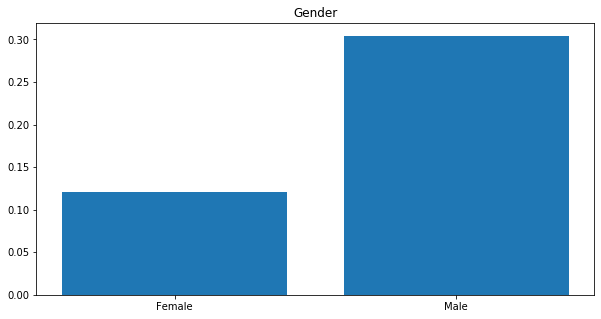

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Gender')
plt.bar([0,1],[women_ver, men_ver])
plt.xticks([0,1], ('Female','Male'))
plt.show()

In [45]:
print(  men_ver / women_ver )

2.5278946890328835


Anteil der Maenner die mehr als 50k verdienen im Vergleich zu den Frauen 2.5 mal so hoch.

In [46]:
#set up bins
bin = [18,40,65,100]
#use pd.cut function can attribute the values into its specific bins
category = pd.cut(set_1.Age,bin)
category = category.to_frame()
category.columns = ['Age_bin']
#concatenate age and its bin
df_age = pd.concat([set_1,category],axis = 1)

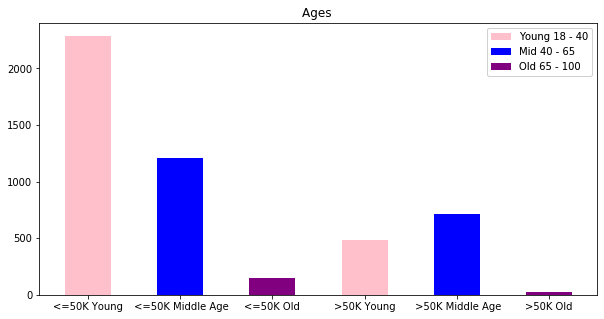

In [47]:
grouped_age = df_age.groupby(['Income','Age_bin']).size()
grouped_age_df =pd.DataFrame(grouped_age)
grouped_age_df.columns = ['Ammount']
pos_age = list(range(len(grouped_age_df['Ammount']))) 
fig, ax = plt.subplots(figsize=(10,5))
p1 = plt.bar(pos_age, 
        #using df['pre_score'] data,
        grouped_age_df['Ammount'], 
        # of width
        0.5,
        color = ["Pink","Blue","Purple","Pink","Blue","Purple"]
        # with label the first value in first_name
       ) 
ax.set_title('Ages ')
legend = plt.legend((p1), ('Young 18 - 40', 'Mid 40 - 65', 'Old 65 - 100'), loc='upper right')
ax.add_artist(legend)

plt.xticks(pos_age, ('<=50K Young',' <=50K Middle Age', '<=50K Old','>50K Young',' >50K Middle Age', '>50K Old'))
plt.show()

In [48]:
grouped_partnership= set_1.groupby(['Income','Partnership']).size()
grouped_partnership_df =pd.DataFrame(grouped_partnership)
grouped_partnership_df.columns = ['Ammount']
print(grouped_partnership_df)

                        Ammount
Income Partnership             
 <=50K  Husband            1082
        Not-in-family      1168
        Other-relative      140
        Own-child           762
        Unmarried           511
        Wife                115
 >50K   Husband             919
        Not-in-family       123
        Other-relative        8
        Own-child             8
        Unmarried            33
        Wife                130


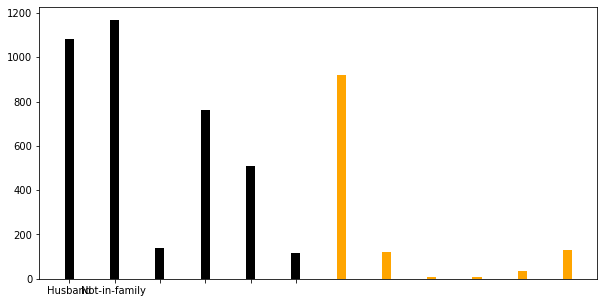

In [49]:
pos_grouped_partnership = list(range(len(grouped_partnership_df['Ammount']))) 
fig, ax = plt.subplots(figsize=(10,5))
p1 = plt.bar(pos_grouped_partnership, 
#using df['pre_score'] data,
grouped_partnership_df['Ammount'], 
# of width
0.2,
color = ["Black","Black","Black","Black","Black","Black","Orange","Orange","Orange","Orange","Orange","Orange"]
# with label the first value in first_name
) 
plt.xticks(pos_age, ('Husband','Not-in-family ', '','', ''))
plt.show()

In [50]:
grouped_ethnicity= set_1.groupby(['Income','Ethnicity']).size()
grouped_ethnicity_df =pd.DataFrame(grouped_ethnicity)
grouped_ethnicity_df.columns = ['Ammount']
print(grouped_ethnicity_df)

                            Ammount
Income Ethnicity                   
 <=50K  Amer-Indian-Eskimo       45
        Asian-Pac-Islander      110
        Black                   448
        Other                    29
        White                  3146
 >50K   Amer-Indian-Eskimo        4
        Asian-Pac-Islander       45
        Black                    66
        Other                     1
        White                  1105


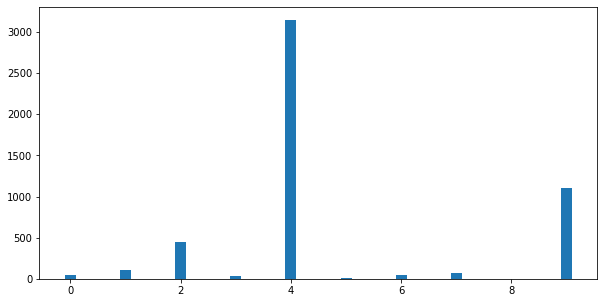

In [51]:
pos_grouped_eth = list(range(len(grouped_ethnicity_df['Ammount']))) 
fig, ax = plt.subplots(figsize=(10,5))
p1 = plt.bar(pos_grouped_eth, 
#using df['pre_score'] data,
grouped_ethnicity_df['Ammount'], 
# of width
0.2
#color = ["Black","Black","Black","Black","Black","Black","Orange","Orange","Orange","Orange","Orange","Orange"]
# with label the first value in first_name
) 

In [52]:
nominal_col = [col for i, col in enumerate(bin_encoded_df.columns) if bin_encoded_df[col].dtype != int and bin_encoded_df[col].dtype != float ]
print(nominal_col)

['Employment', 'Level_of_education', 'Marital_status', 'Employment_area', 'Partnership', 'Ethnicity', 'Country_of birth']


In [53]:
#one hot encoding the nominals
transformed_df = pd.get_dummies(bin_encoded_df, columns=nominal_col)

In [54]:
print(transformed_df[:3])

        Age  Weighting_factor  Schooling_period  Gender  \
0  0.838470         -1.010548          1.152342       1   
1 -0.044139          0.233691         -0.425677       1   
2  1.059122          0.413038         -1.214687       1   

   Gains_on_financial assets  Losses_on_financial_assets  Weekly_working_time  \
0                  -0.146532                   -0.228107            -2.272353   
1                  -0.146532                   -0.228107            -0.042864   
2                  -0.146532                   -0.228107            -0.042864   

   Income  Employment_ ?  Employment_ Federal-gov  ...  \
0       1              0                        0  ...   
1       1              0                        0  ...   
2       1              0                        0  ...   

   Country_of birth_ Portugal  Country_of birth_ Puerto-Rico  \
0                           0                              0   
1                           0                              0   
2            

In [55]:
#Get the Target
y = transformed_df["Income"].values
X = transformed_df.drop(columns=['Income']).values

In [56]:
y.shape

(4999,)

In [57]:
X.shape

(4999, 104)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state=42, stratify=y )

In [59]:
def eval_kerasmodel(n1,n2, d1, d2):

    def classifier():
        model = Sequential()
        model.add(Dense(int(n1), input_dim=X.shape[1], activation='relu'))
        model.add(Dropout(d1))
        model.add(Dense(int(n2), activation='relu'))
        model.add(Dropout(d2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=["acc"])
        return model
    
    model = KerasClassifier(build_fn=classifier, epochs=10, batch_size=20, verbose=0)
    
    def keras_model(X,y):
        kfold = StratifiedKFold(n_splits=int(10), shuffle=True, random_state=2)
        results = cross_val_score(model, X, y, cv=kfold, n_jobs=-2)
        return np.mean(results)
    
    return keras_model(X_train, y_train)

In [60]:
pbounds = {'n1': (1, 10),'n2': (1, 100),'d1': (0, 0.99),'d2': (0, 0.99)}

optimizer = BayesianOptimization(
    f=eval_kerasmodel,
    pbounds=pbounds,
    random_state=seed,
)

optimizer.maximize(
    init_points=4,
    n_iter=4,
)

print(optimizer.max)

|   iter    |  target   |    d1     |    d2     |    n1     |    n2     |
-------------------------------------------------------------------------
|  1        |  0.8411   |  0.07555  |  0.7721   |  4.946    |  72.62    |
|  2        |  0.7566   |  0.9682   |  0.5331   |  5.51     |  8.133    |
|  3        |  0.8426   |  0.2658   |  0.4949   |  7.113    |  80.57    |
|  4        |  0.8295   |  0.3771   |  0.06528  |  3.593    |  91.05    |
|  5        |  0.7784   |  0.8461   |  0.03102  |  9.982    |  57.06    |
|  6        |  0.7571   |  0.0      |  0.99     |  10.0     |  100.0    |
|  7        |  0.7557   |  0.99     |  0.0      |  1.0      |  76.21    |
|  8        |  0.7557   |  0.0      |  0.99     |  1.0      |  30.12    |
{'target': 0.8426349937915802, 'params': {'d1': 0.26575459030085247, 'd2': 0.49488367581730436, 'n1': 7.113069965088465, 'n2': 80.57016457433318}}


In [61]:
def classifier():
    model = Sequential()
    model.add(Dense(int(7), input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.27))
    model.add(Dense(int(80), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=["acc"])
    return model

In [62]:
neuralnet_model  =classifier()
history = neuralnet_model.fit(X_train, 
                              y_train,
                              validation_data=(X_test, y_test), 
                              epochs = 10).history

W0924 05:50:24.946872 140208142161664 deprecation.py:506] From /media/pandoora/DATA/programms/Anaconda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0924 05:50:25.038343 140208142161664 deprecation.py:323] From /media/pandoora/DATA/programms/Anaconda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4499 samples, validate on 500 samples
Epoch 1/10
4499/4499 [==============================] - 0s 63us/sample - loss: 0.5781 - acc: 0.7359 - val_loss: 0.4720 - val_acc: 0.7560
Epoch 2/10
4499/4499 [==============================] - 0s 29us/sample - loss: 0.4330 - acc: 0.7802 - val_loss: 0.3764 - val_acc: 0.8320
Epoch 3/10
4499/4499 [==============================] - 0s 28us/sample - loss: 0.3847 - acc: 0.8073 - val_loss: 0.3562 - val_acc: 0.8360
Epoch 4/10
4499/4499 [==============================] - 0s 29us/sample - loss: 0.3698 - acc: 0.8106 - val_loss: 0.3512 - val_acc: 0.8380
Epoch 5/10
4499/4499 [==============================] - 0s 29us/sample - loss: 0.3610 - acc: 0.8317 - val_loss: 0.3514 - val_acc: 0.8340
Epoch 6/10
4499/4499 [==============================] - 0s 29us/sample - loss: 0.3491 - acc: 0.8422 - val_loss: 0.3489 - val_acc: 0.8340
Epoch 7/10
4499/4499 [==============================] - 0s 29us/sample - loss: 0.3408 - acc: 0.8482 - val_loss: 0.3461 - val_acc: 0

In [63]:
y_predict = neuralnet_model.predict(X_test)

In [64]:
y_predict[:2]

array([[0.9053623 ],
       [0.98389703]], dtype=float32)

In [65]:
prediction = rounding(y_predict, 0.90)

In [67]:
prediction.shape

(500, 1)

In [68]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.57      0.63       122
           1       0.87      0.92      0.89       378

    accuracy                           0.83       500
   macro avg       0.78      0.75      0.76       500
weighted avg       0.83      0.83      0.83       500



In [69]:
cm = confusion_matrix(y_test, prediction)

In [76]:
print(cm)

[[ 70  52]
 [ 31 347]]


In [77]:
from sklearn.metrics import roc_curve, auc

In [78]:
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [80]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)

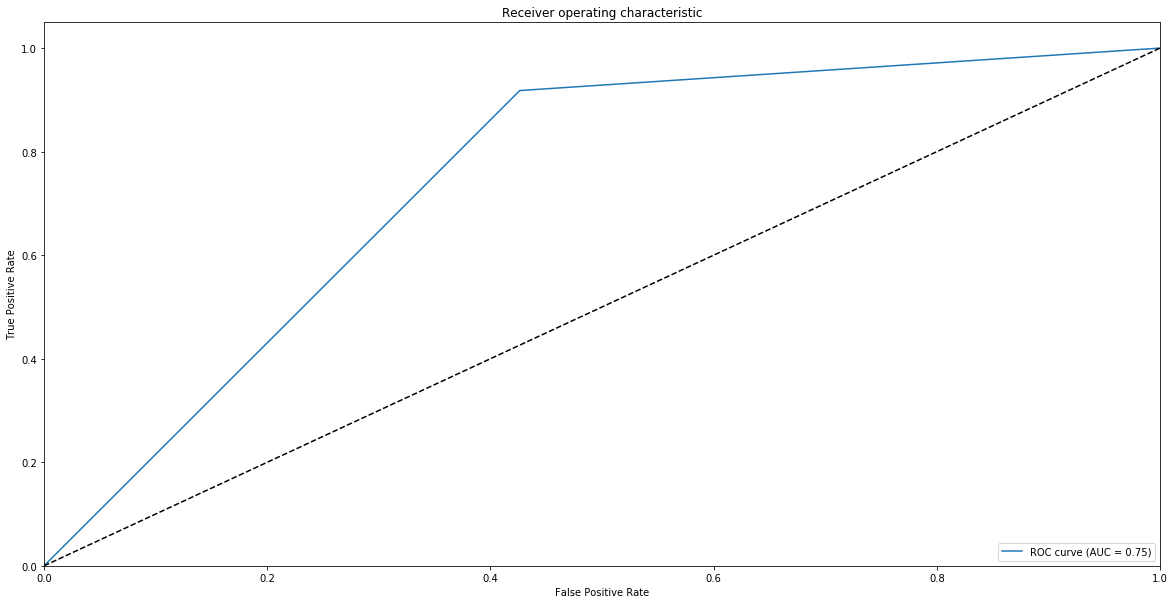

In [81]:
plot_roc_curves([fpr], [tpr])

In [82]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    except AttributeError:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

In [71]:
def eval_random_forest(f):
    
    def Random_forest(train, test, f):
        X_train = X[train]
        y_train = y[train]
        
        X_test  = X[test]
        y_test  = y[test]   
        
        rfc = RandomForestClassifier(int(f))
        rfc.fit(X_train, y_train)
        
        score = rfc.score(X_test, y_test)
    
        return score
   
    boot = StratifiedShuffleSplit(n_splits=int(10), test_size = 1 /int(10))

    rfc_score = np.array(Parallel(n_jobs=-2)(delayed(Random_forest)(train,test,f) for train,test in boot.split(X, y)))

    return np.mean(rfc_score)    

In [72]:
pbounds = {'f': (1, 100)}

optimizer = BayesianOptimization(
    f=eval_random_forest,
    pbounds=pbounds,
    random_state=seed,
)

optimizer.maximize(
    init_points=10,
    n_iter=10,
)

print(optimizer.max)

|   iter    |  target   |     f     |
-------------------------------------
|  1        |  0.8292   |  8.555    |
|  2        |  0.8448   |  78.21    |
|  3        |  0.8442   |  44.4     |
|  4        |  0.8368   |  72.62    |
|  5        |  0.8292   |  97.82    |
|  6        |  0.8452   |  54.31    |
|  7        |  0.8392   |  50.61    |
|  8        |  0.818    |  8.133    |
|  9        |  0.8372   |  27.58    |
|  10       |  0.8306   |  50.49    |
|  11       |  0.8398   |  88.61    |
|  12       |  0.8292   |  35.8     |
|  13       |  0.829    |  17.03    |
|  14       |  0.797    |  1.0      |
|  15       |  0.841    |  64.75    |
|  16       |  0.8412   |  83.62    |
|  17       |  0.833    |  100.0    |
|  18       |  0.8334   |  12.72    |
|  19       |  0.832    |  22.69    |
|  20       |  0.8364   |  40.29    |
{'target': 0.8452, 'params': {'f': 54.311091170632935}}


In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(neuralnet_model, ax)

In [75]:
print("Check for Missing values in nominal")
for i,col in enumerate(nominal_col):
    print(i,"Number of ? contains in ",col, sum(znorm_df[col].str.contains('?', regex=False)))

Check for Missing values in nominal
0 Number of ? contains in  Employment 331
1 Number of ? contains in  Level_of_education 0
2 Number of ? contains in  Marital_status 0
3 Number of ? contains in  Employment_area 331
4 Number of ? contains in  Partnership 0
5 Number of ? contains in  Ethnicity 0
6 Number of ? contains in  Country_of birth 97


integer cols: ['Age', 'Weighting_factor', 'Schooling_period', 'Gains_on_financial assets', 'Losses_on_financial_assets', 'Weekly_working_time']
